# Ufc Analysis using Bayesian Networks


Adding imports

In [37]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation
from pgmpy.estimators import BayesianEstimator
from pgmpy.metrics import correlation_score
from pgmpy.metrics import log_likelihood_score
import gradio as gr
import networkx as nx

Read the database

In [38]:
db = pd.read_csv('ufc_fighters.csv')
db.head()

,First Name,Last Name,Nickname,Height,Weight,Reach,Stance,Wins,Losses,Draws
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5,3,0
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4,6,0
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28,4,0
3,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10,15,0
4,Hamdy,Abdelwahab,The Hammer,"6' 2""",264 lbs.,"72.0""",Southpaw,5,0,0


### Clean and format the database

In [39]:
# The nickname is not relevant for the analysis, so we can drop it
db = db.drop('Nickname', axis=1)

In [40]:
#The stance column has some missing values, let's count them
db['Stance'].isnull().sum()

839

After a brief research, we know that the missing values related to the stance column are there because every fighter with 'NaN' value has his own personal fighting style that can't be categorized, so we create a new type called "Personal" and we substitute nan values with it

In [41]:
db['Stance'] = db['Stance'].fillna('Personal')

In [42]:
#Let's check the missing values in the rest of the columns
db.isnull().sum()

First Name    9
Last Name     0
Height        0
Weight        0
Reach         0
Stance        0
Wins          0
Losses        0
Draws         0
dtype: int64

In [43]:
#The first name column has some missing values, let's see the rows containing them
db[db['First Name'].isnull()]

,First Name,Last Name,Height,Weight,Reach,Stance,Wins,Losses,Draws
39,NaN,Alatengheili,"5' 5""",135 lbs.,"66.0""",Orthodox,16,8,2
129,NaN,Angga,"5' 7""",145 lbs.,"68.0""",Orthodox,13,3,0
141,NaN,Aoriqileng,"5' 7""",135 lbs.,"69.0""",Orthodox,24,9,0
170,NaN,Asjabharan,"5' 6""",135 lbs.,--,Personal,7,6,0
218,NaN,Balajin,"5' 9""",145 lbs.,"72.0""",Orthodox,23,4,0
2124,NaN,Maheshate,"6' 0""",155 lbs.,"71.0""",Orthodox,9,2,0
3476,NaN,Sumudaerji,"5' 8""",125 lbs.,"72.0""",Southpaw,16,5,0
3868,NaN,Wulijiburen,"5' 9""",135 lbs.,"69.0""",Orthodox,20,9,0
3898,NaN,Yibugele,--,155 lbs.,--,Personal,21,11,1


Since the rows are so few, we can try to save them by doing a little research.  
By searching through the sites that catalogues every fighter, like [this](https://www.espn.com/mma/) , we can fill the missing first names with proper values

In [44]:
# The fighter Alatengheili has a missing first name, and the last name is a combination of both names, so let's fix that
db.loc[db['Last Name'] == 'Alatengheili', ['First Name', 'Last Name']] = ['Heili', 'Alateng']
#The fighter Angga has a missing first name, so let's fix that
db.loc[db['Last Name'] == 'Angga', 'First Name'] = 'Hans'
# The fighter Aoriqileng has a missing first name, and the last name is a combination of both names, so let's fix that
db.loc[db['Last Name'] == 'Aoriqileng', ['First Name', 'Last Name']] = ['Aori', 'Qileng']
#The fighter Asjabharan has a missing first name, so let's fix that
db.loc[db['Last Name'] == 'Asjabharan', 'First Name'] = 'Baataryn'
# The fighter Balajin has a missing first name, and the last name is a combination of both names, so let's fix that
db.loc[db['Last Name'] == 'Balajin', ['First Name', 'Last Name']] = ['Ba', 'Lajin']
#The fighter Maheshate has a missing first name, so let's fix that
db.loc[db['Last Name'] == 'Maheshate', 'First Name'] = 'Hayisaer'
# The fighter Sumudaerji has a missing first name, and the last name is a combination of both names, so let's fix that
db.loc[db['Last Name'] == 'Sumudaerji', ['First Name', 'Last Name']] = ['Su', 'Mudaerji']
#The fighter Wulijiburen has a missing first name, and the last name is a combination of both names, so let's fix that
db.loc[db['Last Name'] == 'Wulijiburen', ['First Name', 'Last Name']] = ['Wuliji', 'Buren']


In [45]:
#The last missing value in the first name column is for the fighter Yibugele, which we can't find any information about 
#so let's drop that row
db = db.dropna()
db.isnull().sum()

First Name    0
Last Name     0
Height        0
Weight        0
Reach         0
Stance        0
Wins          0
Losses        0
Draws         0
dtype: int64

Now we are going to be deal with the values -- inside the data, and fix them

In [46]:
#Let's count the number of -- in the data, which are other missing values
db[db == '--'].count()

First Name       0
Last Name        0
Height         296
Weight          78
Reach         1938
Stance           0
Wins             0
Losses           0
Draws            0
dtype: int64

In [47]:
#Since both the height and weight columns are important for the analysis, we can't imply any value for them
#so let's drop the rows containing missing values
db = db[(db['Height'] != '--') & (db['Weight'] != '--')]

In [48]:
#Let's count the number of instances for each reach value
db['Reach'].value_counts()

Reach
--       1637
72.0"     187
71.0"     184
70.0"     181
73.0"     181
74.0"     168
75.0"     159
69.0"     129
68.0"     119
76.0"     112
67.0"      98
77.0"      92
66.0"      76
78.0"      60
65.0"      58
64.0"      45
79.0"      41
63.0"      35
80.0"      31
62.0"      16
81.0"      12
61.0"       8
82.0"       8
60.0"       3
84.0"       3
83.0"       3
59.0"       1
58.0"       1
Name: count, dtype: int64

In [49]:
#The reach column could have been interesting for the analysis, but it has a lot of missing values, so let's drop it
db = db.drop('Reach', axis=1)

We'll create one new column related to the win percentage, and merge the name and surname column in a Fighter column

In [50]:
db['Win Percentage (%)'] = ((db['Wins'] / (db['Wins'] + db['Losses'] + db['Draws'])) * 100).round(1)

In [51]:
#We merge the name and surname column in a Fighter column, and set it as the first column
fighters = db['First Name'] + ' ' + db['Last Name']
db.insert(0, 'Fighter', fighters)
db = db.drop(['First Name', 'Last Name'], axis=1)


### Discretization

To use a Bayesian Network effectively, it is necessary to discretize the continuous variables in the dataset.  
This is important because Bayesian Networks operate on discrete variables and assume that the relationships between variables are based on discrete states.  
We can discretize win percentage, by creating a column winrate.

In [52]:
#We can discretize the win percentage in 5 bins
db['Winrate'] = pd.cut(db['Win Percentage (%)'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

Weight and Height are already discretized, but it was done poorly, with too many singular values instead of using ranges.  
To fix this, we need to convert both columns back in numeric values, and discretize them again.  
We can do that by using the official UFC weight categories for the weight, and ranges for the heights.  

In [53]:
#We can convert the height column to a numeric type, in cm
def height_to_cm(height):
    height_parts = height.split("'")
    feet = int(height_parts[0].strip())
    inches = int(height_parts[1].strip().replace("\"", ""))
    height_inch = feet * 12 + inches
    return round(height_inch * 2.54, 1)

db["Height"] = db["Height"].apply(height_to_cm)

In [54]:
#We can convert the weight column to a numeric type, in lbs
def weight_to_lbs(weight):
    return int(weight.replace(' lbs.', ''))

db["Weight"] = db["Weight"].apply(weight_to_lbs)

In [55]:
#We need to discretize the weight column, using the UFC weight classes
weight_classes = ['Strawweight', 'Flyweight', 'Bantamweight', 'Featherweight', 'Lightweight', 'Welterweight', 'Middleweight', 'Light Heavyweight', 'Heavyweight']
weight_bins = [0, 115, 125, 135, 145, 155, 170, 185, 205, 265]
db['Weight'] = pd.cut(db['Weight'], bins=weight_bins, labels=weight_classes)

In [56]:
#We need to discretize the height column, using centimeters numeric intervals as classes names
height_bins = [0, 160, 170, 180, 190, 200, 210]
height_classes = [f'{height_bins[i]}-{height_bins[i+1]}' for i in range(len(height_bins)-1)]
db['Height'] = pd.cut(db['Height'], bins=height_bins, labels=height_classes)

In [57]:
#Let's drop the last nan values
db = db.dropna()
db.isnull().sum()

Fighter               0
Height                0
Weight                0
Stance                0
Wins                  0
Losses                0
Draws                 0
Win Percentage (%)    0
Winrate               0
dtype: int64

Now the database is ready for our analysis

In [58]:
db.head()

,Fighter,Height,Weight,Stance,Wins,Losses,Draws,Win Percentage (%),Winrate
1,Danny Abbadi,180-190,Lightweight,Orthodox,4,6,0,40.0,Low
2,Nariman Abbasov,170-180,Lightweight,Orthodox,28,4,0,87.5,Very High
3,David Abbott,180-190,Heavyweight,Switch,10,15,0,40.0,Low
4,Hamdy Abdelwahab,180-190,Heavyweight,Southpaw,5,0,0,100.0,Very High
5,Shamil Abdurakhimov,190-200,Heavyweight,Orthodox,20,8,0,71.4,High


We want to compare the results and the usefullness between using a classification model (Decision Tree) and using a Bayesan Network.  
We'll start with the classification model.

### Classification Model (Decision Tree)

Decision Tree Classifier is a good model to compute probability in Machine Learning because it can be easily interpreted and visualized, making it easy to understand how decisions are being made. Additionally, Decision Trees provide an intuitive way to calculate probabilities by aggregating the probabilities of different class labels at each leaf node.

In [59]:
#We set the parameters for the classification analysis
X = db[['Height', 'Weight', 'Stance']]
y = db['Winrate']

#We need to convert the categorical columns to a numeric type
X = pd.get_dummies(X)

#We split the data into training and testing sets, and fit the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

dtmodel = DecisionTreeClassifier(max_depth=3, random_state=42)
dtmodel.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3, random_state=42)

Let's plot the tree

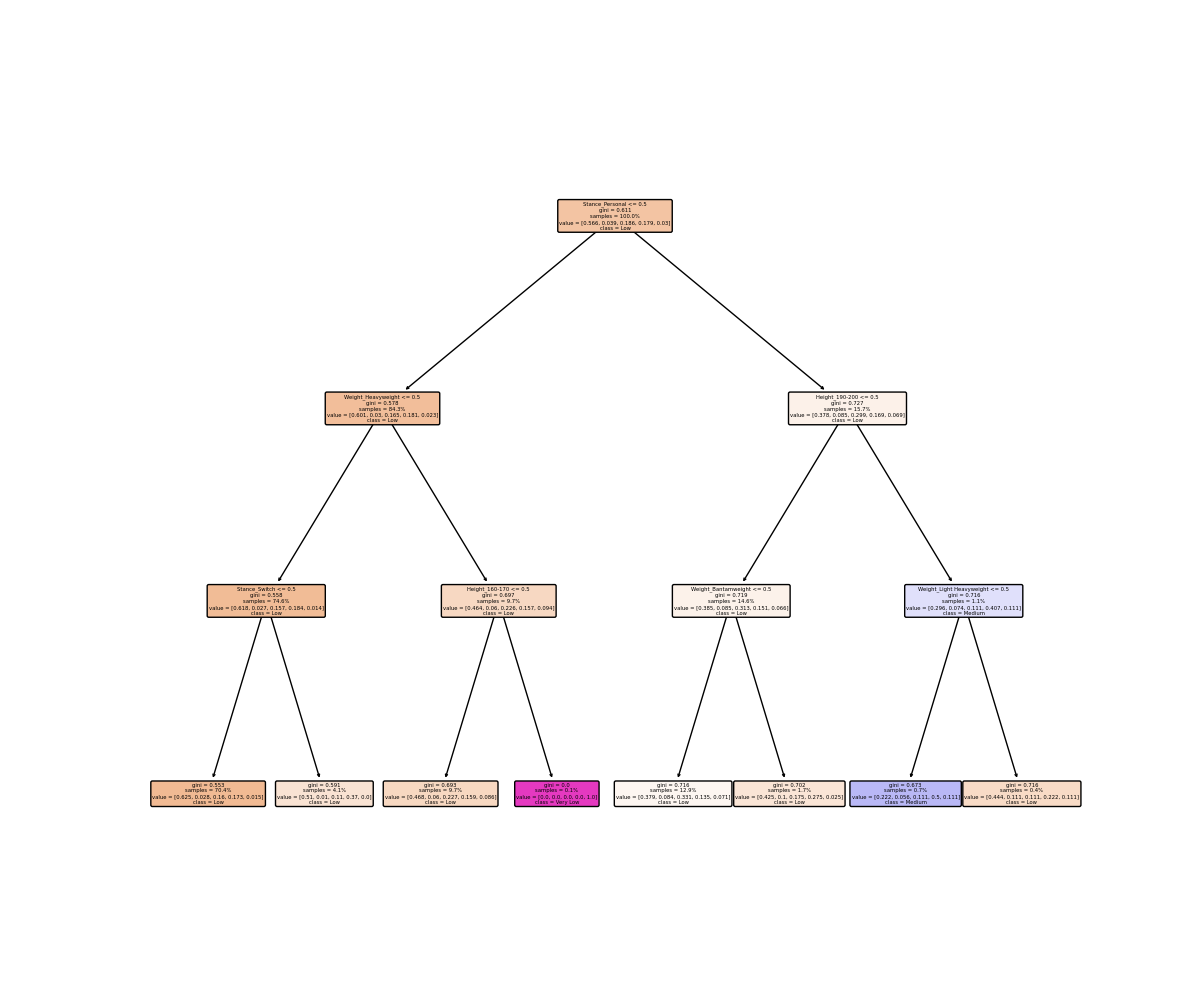

In [60]:
plt.figure(figsize = (12,10))
plot_tree(dtmodel
          , filled=True
          , feature_names = X.columns
          , class_names = y.unique()
          , rounded = True
          , proportion = True
         );

Let's measure the accuracy of the Decision Tree and his ability to predict

In [61]:
y_pred = dtmodel.predict(X_test)
print(f"The accuracy of the model in the test set is { round(accuracy_score(y_test, y_pred)*100,3)} %")

The accuracy of the model in the test set is 56.397 %


The accuracy is more than 50%, which is not bad giving the discretization of every class, but an accuracy lower than 70% makes the model very unreliable

### Bayesan Network

In [62]:
bnmodel = BayesianNetwork([('Height', 'Weight'),
                         ('Height', 'Stance'),
                         ('Weight', 'Stance'),
                         ('Height', 'Winrate'),
                         ('Weight', 'Winrate'), 
                         ('Stance', 'Winrate'),])

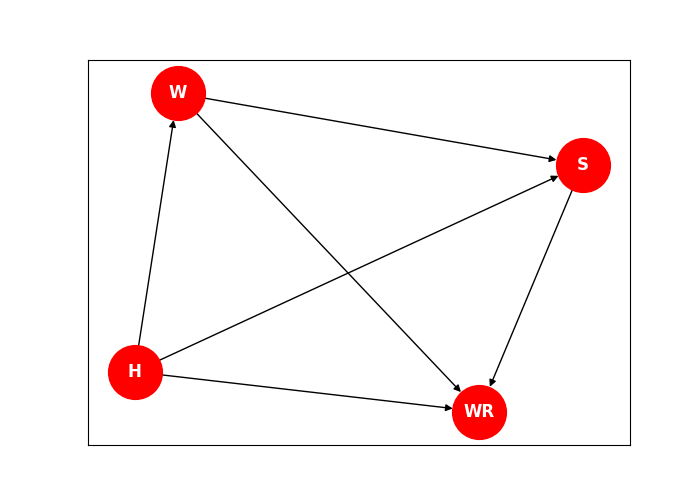

In [63]:
# We can visualize the structure of the network
G = nx.relabel_nodes(bnmodel, {'Height':'H', 'Weight':'W', 'Stance':'S', 'Winrate':'WR'})

plt.figure(figsize=(7, 5))
nx.draw_networkx(G, node_color='r', node_size=1500, with_labels=True, 
               font_color='w', font_weight='bold')
plt.title('Structure of the Bayesian Network', size=15, fontdict={'weight':'bold'}, color='w')
plt.show()

We can prepare the database, just like we did with the previous classifier

In [64]:
data = db[['Height', 'Weight', 'Stance', 'Winrate']]

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

ratio = 0.75

train_size = int(data.shape[0]*ratio)
 
# Split data into test and train
train = data[0:train_size]
test = data[train_size:]

Instead of using Maximum Likelihood Estimator, which could lead to overfitting related to the data already present in the dataset, we are gonna use Bayesian Estimator.  
By using specifically BDeu (Bayesian Dirichlet equivalent uniform prior), we can have a more conservative estimation of CPD by putting every node on an almost equiprobable level

In [65]:
#Using the BayesianEstimator, we can estimate the CPDs for the model
bnmodel.fit(train, estimator=BayesianEstimator, prior_type="BDeu")

In [66]:
# Print all the learned CPTs
for cpd in bnmodel.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print(cpd, '\n')

CPT of Height
+-----------------+------------+
| Height(0-160)   | 0.0291543  |
+-----------------+------------+
| Height(160-170) | 0.119761   |
+-----------------+------------+
| Height(170-180) | 0.380856   |
+-----------------+------------+
| Height(180-190) | 0.37124    |
+-----------------+------------+
| Height(190-200) | 0.0938733  |
+-----------------+------------+
| Height(200-210) | 0.00511588 |
+-----------------+------------+ 

CPT of Weight
+---------------------------+-----+----------------------+
| Height                    | ... | Height(200-210)      |
+---------------------------+-----+----------------------+
| Weight(Bantamweight)      | ... | 0.006693440428380184 |
+---------------------------+-----+----------------------+
| Weight(Featherweight)     | ... | 0.006693440428380184 |
+---------------------------+-----+----------------------+
| Weight(Flyweight)         | ... | 0.006693440428380184 |
+---------------------------+-----+----------------------+
| Weight(H

We can check the model for any errors or uneven probabilities

In [67]:
if(bnmodel.check_model()):
    print("The model is correctly defined")
else:
    print("The model presents imbalances")

The model is correctly defined


We can check the performance of the model using correlation score and log likelihood score

In [68]:
print(correlation_score(bnmodel, test, test="chi_square", significance_level=0.05))
print(log_likelihood_score(bnmodel, test))

0.0
-4791.404079847417


The correlation score is 0.0, which is basically perfect, since "absense of correlation/d-separation is considered as the positive class for computing the metrics", as stated by the documentation.   
The log likelihood has still a pretty high score, especially compared to other models, with errors between -10.000 and -6000.
We can conclude that the model has a pretty good level of reliability, altought there's surely a bit of overfitting related to the small sample database.

### Utils

A really interesting utility function lies in the ability to make predictions with the Bayesian Network.  
Using different types of inferences we can estimate a probability distribution for the winrate of a new fighter.  
We can explore one type of approximate inference and two types of exact inference, comparing the results.

In [69]:
#Approximate Inference function using approximate prediction
def ApproxPrediction(win, evidence):
    infer = ApproxInference(bnmodel)
    string = ''
    lis = list(evidence.items())
    
    for i, a in enumerate(lis):
        string += a[0] + '=' + str(a[1])
        if i != len(lis) - 1:
            string += ', '
    
    prob = infer.query([win], n_samples = 10000 ,evidence=evidence, show_progress=False)
    
    print('Prevision of {} given {}\n'.format(win, string))
    print(prob)


ApproxPrediction('Winrate', {'Height': '180-190', 'Weight': 'Heavyweight', 'Stance': 'Orthodox'})

Prevision of Winrate given Height=180-190, Weight=Heavyweight, Stance=Orthodox

+--------------------+----------------+
| Winrate            |   phi(Winrate) |
+====================+================+
| Winrate(Low)       |         0.0926 |
+--------------------+----------------+
| Winrate(High)      |         0.3934 |
+--------------------+----------------+
| Winrate(Medium)    |         0.2255 |
+--------------------+----------------+
| Winrate(Very High) |         0.1857 |
+--------------------+----------------+
| Winrate(Very Low)  |         0.1028 |
+--------------------+----------------+


In [70]:
#Exact Inference function using variable elimination
def ElimPrediction(win, evidence):
    infer = VariableElimination(bnmodel)
    string = ''
    lis = list(evidence.items())
    
    for i, a in enumerate(lis):
        string += a[0] + '=' + str(a[1])
        if i != len(lis) - 1:
            string += ', '
    
    prob = infer.query([win], evidence=evidence, show_progress=False)
    most_prob = infer.map_query([win], evidence=evidence, show_progress=False)
    
    print('Prevision of {} given {}\n'.format(win, string))
    print(prob)
    print('\nThe most probable value is: ', most_prob)


ElimPrediction('Winrate', {'Height': '180-190', 'Weight': 'Heavyweight', 'Stance': 'Orthodox'})

Prevision of Winrate given Height=180-190, Weight=Heavyweight, Stance=Orthodox

+--------------------+----------------+
| Winrate            |   phi(Winrate) |
+====================+================+
| Winrate(High)      |         0.3917 |
+--------------------+----------------+
| Winrate(Low)       |         0.0928 |
+--------------------+----------------+
| Winrate(Medium)    |         0.2268 |
+--------------------+----------------+
| Winrate(Very High) |         0.1856 |
+--------------------+----------------+
| Winrate(Very Low)  |         0.1031 |
+--------------------+----------------+

The most probable value is:  {'Winrate': 'High'}


In [71]:
#Exact Inference function using belief propagation
def BeliefPrediction(hieght, weight, stance):
    evidence = {'Height': hieght, 'Weight': weight, 'Stance': stance}
    infer = BeliefPropagation(bnmodel)
    infer.calibrate()
    string = ''
    lis = list(evidence.items())
    
    for i, a in enumerate(lis):
        string += a[0] + '=' + str(a[1])
        if i != len(lis) - 1:
            string += ', '
    
    prob = infer.query(['Winrate'], evidence=evidence, show_progress=False)
    most_prob = infer.map_query(['Winrate'], evidence=evidence, show_progress=False)

    results = ['Prevision of winrate given {}\n'.format(string), str(prob), '\nThe most probable value is: ' + str(most_prob)]
    return ('\n'.join(results))

print(BeliefPrediction('180-190', 'Heavyweight', 'Orthodox'))


Prevision of winrate given Height=180-190, Weight=Heavyweight, Stance=Orthodox

+--------------------+----------------+
| Winrate            |   phi(Winrate) |
+====================+================+
| Winrate(High)      |         0.3917 |
+--------------------+----------------+
| Winrate(Low)       |         0.0928 |
+--------------------+----------------+
| Winrate(Medium)    |         0.2268 |
+--------------------+----------------+
| Winrate(Very High) |         0.1856 |
+--------------------+----------------+
| Winrate(Very Low)  |         0.1031 |
+--------------------+----------------+

The most probable value is: {'Winrate': 'High'}


### Final Api 

To complete the work, we'll create a demo of a user friendly app that uses belief prediction to help the user guess the winrate of a specific present or new fighter

In [72]:
demo = gr.Interface(
    BeliefPrediction,
    [
        gr.Dropdown(
            ['0-160', '160-170', '170-180', '180-190', '190-200', '200-210'], label="Height", info="The height is in cm intervals"
        ),
        gr.Dropdown(
            ["Strawweight", "Flyweight", "Bantamweight", "Featherweight", "Lightweight", "Welterweight", "Middleweight", "Light Heavyweight", "Heavyweight"], label="Weight", info="The weight is in Ufc weight classes"
        ),
        gr.Dropdown(
            ["Orthodox", "Southpaw", "Switch", "Personal"], label="Stance", info="The stance is the fighting stance of the fighter"
        )
    ],
    [gr.Textbox(label="Prediction", type="text")],
    title="Fighter Winrate Prediction",
    description="This application predicts the winrate of a fighter given the height, weight and stance",
)

demo.launch()

INFO:httpx:HTTP Request: GET http://127.0.0.1:7861/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-initiated-analytics/ "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.gradio.app/gradio-launched-telemetry/ "HTTP/1.1 200 OK"
